In [1]:
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [3]:
listings_clean = pd.read_csv(r'/content/listings_clean.csv').iloc[:,1:]
reviews_clean = pd.read_csv(r'/content/reviews_clean.csv').iloc[:,1:]

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
reviews_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210152 entries, 0 to 210151
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   listing_id            210152 non-null  int64  
 1   Cust_sentiment_score  210152 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.2 MB


In [6]:
reviews_gp = reviews_clean.groupby('listing_id')['Cust_sentiment_score'].mean().to_frame()

In [7]:
listings_merge = listings_clean.merge(reviews_gp, how='left', left_on='id', right_on='listing_id')

In [8]:
listings_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6209 entries, 0 to 6208
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6209 non-null   int64  
 1   host_response_time           6209 non-null   int64  
 2   host_response_rate           6209 non-null   float64
 3   host_acceptance_rate         6209 non-null   float64
 4   host_is_superhost            6209 non-null   int64  
 5   host_has_profile_pic         6209 non-null   int64  
 6   host_identity_verified       6209 non-null   int64  
 7   price                        6209 non-null   float64
 8   has_availability             6209 non-null   int64  
 9   review_scores_rating         6209 non-null   float64
 10  review_scores_accuracy       6209 non-null   float64
 11  review_scores_cleanliness    6209 non-null   float64
 12  review_scores_checkin        6209 non-null   float64
 13  review_scores_comm

In [9]:
# Fill missing value with mean for Cust_sentiment_score
listings_merge['Cust_sentiment_score'] = listings_merge['Cust_sentiment_score'].fillna(listings_merge['Cust_sentiment_score'].mean())

In [10]:
# Fill outlier with mean
listings_merge.iloc[listings_merge['price'][listings_merge['price'] > 1000].index,listings_merge.columns.get_loc('price')] = listings_merge['price'].mean()

# Functions

In [11]:
# Grid search cross-validation for choosing best parameters
def choose_param(model, X_train, y_train, param_grid):
    grid = GridSearchCV(model, param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_param = grid.best_params_
    #print(best_param)
    return best_param

In [12]:
# Modeling
def classifer_model(model, Xtrain, ytrain):
    # Train model
    y_pred = model.predict(Xtrain)
    y_proba = model.predict_proba(Xtrain)
    
    # Model result
    acc = metrics.accuracy_score(ytrain, y_pred)
    #print(' Acc: ', acc)
    pre = metrics.precision_score(ytrain, y_pred, average='macro', zero_division=0)
    #print(' Pre: ', pre)
    recall = metrics.recall_score(ytrain, y_pred, average='macro')
    #print(' Recall: ', recall)
    f1 = metrics.f1_score(ytrain, y_pred, average='macro')
    #print(' F1: ', f1)
    roc_auc = metrics.roc_auc_score(ytrain, y_proba, average='macro', multi_class='ovr')
    #print(' Roc_Auc: ', roc_auc)

    return acc,pre,recall,f1,roc_auc

In [13]:
# Modeling baseline
def dc_model(model, Xtrain, ytrain):
    # Train model
    y_pred = model.predict(Xtrain)
    
    # Model result
    acc = metrics.accuracy_score(ytrain, y_pred)
    #print(' Acc: ', acc)
    pre = metrics.precision_score(ytrain, y_pred, average='macro', zero_division=0)
    #print(' Pre: ', pre)
    recall = metrics.recall_score(ytrain, y_pred, average='macro')
    #print(' Recall: ', recall)
    f1 = metrics.f1_score(ytrain, y_pred, average='macro')
    #print(' F1: ', f1)

    return acc,pre,recall,f1

In [14]:
# Models table
def eva_result(name,model,Xtrain,ytrain,Xtest,ytest):
    df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC_AUC'))

    model.fit(Xtrain, ytrain)
    acc, p, r, f1, roc_auc_train = classifer_model(model, Xtrain, ytrain)
    df_result.loc[0] = [name, 'train', acc, p, r, f1, roc_auc_train]

    acc, p, r, f1, roc_auc_test = classifer_model(model, Xtest, ytest)
    df_result.loc[1] = [name, 'test', acc, p, r, f1, roc_auc_test]
    return df_result

In [15]:
# Baseline table
def dc_result(name,model,Xtrain,ytrain,Xtest,ytest):
    df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score'))

    model.fit(Xtrain, ytrain)
    acc, p, r, f1 = dc_model(model, Xtrain, ytrain)
    df_result.loc[0] = [name, 'train', acc, p, r, f1]

    acc, p, r, f1 = dc_model(model, Xtest, ytest)
    df_result.loc[1] = [name, 'test', acc, p, r, f1]
    return df_result

# Create bins for targets

In [16]:
# Create equal probability bins at the PENTILES of RATING
labels4 = [1,2,3,4]
labels5 = [1,2,3,4,5]

def bin_scores(df, bin_name, column_score, labels):
    df[bin_name] = pd.qcut(
            df[column_score],
            q=6,
            duplicates='drop',
            labels=labels
            )

bin_scores(listings_merge,'rating_bin','review_scores_rating',labels5)
bin_scores(listings_merge,'accuracy_bin','review_scores_accuracy',labels5)
bin_scores(listings_merge,'cleanliness_bin','review_scores_cleanliness',labels5)
bin_scores(listings_merge,'checkin_bin','review_scores_checkin',labels4)
bin_scores(listings_merge,'communication_bin','review_scores_communication',labels4)
bin_scores(listings_merge,'location_bin','review_scores_location',labels5)
bin_scores(listings_merge,'value_bin','review_scores_value',labels5)   

In [17]:
listings_merge.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,price,has_availability,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,bathroom_per_person,bedroom_per_person,bed_per_person,Dn Laoghaire-Rathdown,Dublin City,Fingal,South Dublin,Entire home/apt,Hotel room,Private room,Shared room,Oven,Fire extinguisher,Dryer,Hangers,Kitchen,Cooking basics,Breakfast,Microwave,Heating,Washer,First aid kit,Hot water,Iron,Dishwasher,Shampoo,Luggage dropoff allowed,Coffee maker,Essentials,Refrigerator,Bed linens,Wifi,Self check-in,Pets allowed,Elevator,Host_sentiment_score,Cust_sentiment_score,rating_bin,accuracy_bin,cleanliness_bin,checkin_bin,communication_bin,location_bin,value_bin
0,44077,1,1.00,0.99,1,1,1,70.0,1,4.78,4.83,4.74,4.93,4.93,4.66,4.82,0,1.85,0.75,0.50,1.00,1,0,0,0,0,0,1,0,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0.9808,0.897973,3,3,3,3,3,2,4
1,85156,1,1.00,0.99,1,1,1,67.0,1,4.79,4.86,4.74,4.90,4.88,4.64,4.78,0,1.53,0.75,0.50,0.50,1,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0.9544,0.907040,3,3,3,3,2,2,4
2,159889,1,1.00,0.95,0,1,1,45.0,1,4.74,4.77,4.71,4.86,4.90,4.63,4.74,0,2.78,2.00,1.00,1.00,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,0,0,0.9524,0.817610,3,2,3,2,3,2,4
3,162809,1,0.92,0.87,1,1,1,80.0,1,4.84,4.88,4.85,4.95,4.97,4.77,4.85,0,3.68,0.25,0.33,0.67,1,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0.9844,0.864304,4,3,4,3,4,3,5
4,165828,1,1.00,0.91,0,1,1,251.0,1,4.63,4.89,4.69,4.81,4.75,4.34,4.55,1,0.48,0.20,0.20,0.60,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,1,0,0,1,1,1,1,0,1,0,0,0,0.9702,0.797778,2,3,3,2,2,1,2


In [18]:
# Drop the original targets that are not needed
original_targets = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value']
targets = ['rating_bin', 'accuracy_bin', 'cleanliness_bin', 'checkin_bin', 'communication_bin', 'location_bin', 'value_bin']

listings_merge = listings_merge.drop(columns = original_targets)
  
listings_merge.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,price,has_availability,instant_bookable,reviews_per_month,bathroom_per_person,bedroom_per_person,bed_per_person,Dn Laoghaire-Rathdown,Dublin City,Fingal,South Dublin,Entire home/apt,Hotel room,Private room,Shared room,Oven,Fire extinguisher,Dryer,Hangers,Kitchen,Cooking basics,Breakfast,Microwave,Heating,Washer,First aid kit,Hot water,Iron,Dishwasher,Shampoo,Luggage dropoff allowed,Coffee maker,Essentials,Refrigerator,Bed linens,Wifi,Self check-in,Pets allowed,Elevator,Host_sentiment_score,Cust_sentiment_score,rating_bin,accuracy_bin,cleanliness_bin,checkin_bin,communication_bin,location_bin,value_bin
0,44077,1,1.00,0.99,1,1,1,70.0,1,0,1.85,0.75,0.50,1.00,1,0,0,0,0,0,1,0,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0.9808,0.897973,3,3,3,3,3,2,4
1,85156,1,1.00,0.99,1,1,1,67.0,1,0,1.53,0.75,0.50,0.50,1,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0.9544,0.907040,3,3,3,3,2,2,4
2,159889,1,1.00,0.95,0,1,1,45.0,1,0,2.78,2.00,1.00,1.00,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,0,0,0.9524,0.817610,3,2,3,2,3,2,4
3,162809,1,0.92,0.87,1,1,1,80.0,1,0,3.68,0.25,0.33,0.67,1,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0.9844,0.864304,4,3,4,3,4,3,5
4,165828,1,1.00,0.91,0,1,1,251.0,1,1,0.48,0.20,0.20,0.60,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,1,0,0,1,1,1,1,0,1,0,0,0,0.9702,0.797778,2,3,3,2,2,1,2


In [19]:
for target in targets:
  print(listings_merge[target].value_counts(),'\n')

5    2032
2    1140
4    1040
1    1039
3     958
Name: rating_bin, dtype: int64 

5    2049
2    1102
1    1064
4    1024
3     970
Name: accuracy_bin, dtype: int64 

5    2012
3    1074
4    1044
1    1040
2    1039
Name: cleanliness_bin, dtype: int64 

4    2988
3    1137
1    1075
2    1009
Name: checkin_bin, dtype: int64 

4    3064
2    1068
1    1056
3    1021
Name: communication_bin, dtype: int64 

5    2032
1    1083
2    1052
3    1042
4    1000
Name: location_bin, dtype: int64 

5    2049
3    1107
1    1056
2    1034
4     963
Name: value_bin, dtype: int64 



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


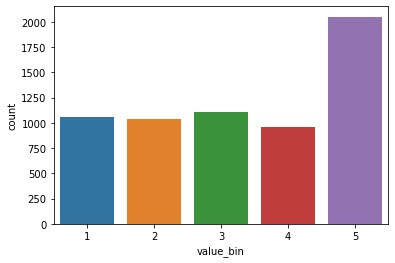

In [20]:
# Visualize the Split
sns.countplot(listings_merge['value_bin'])

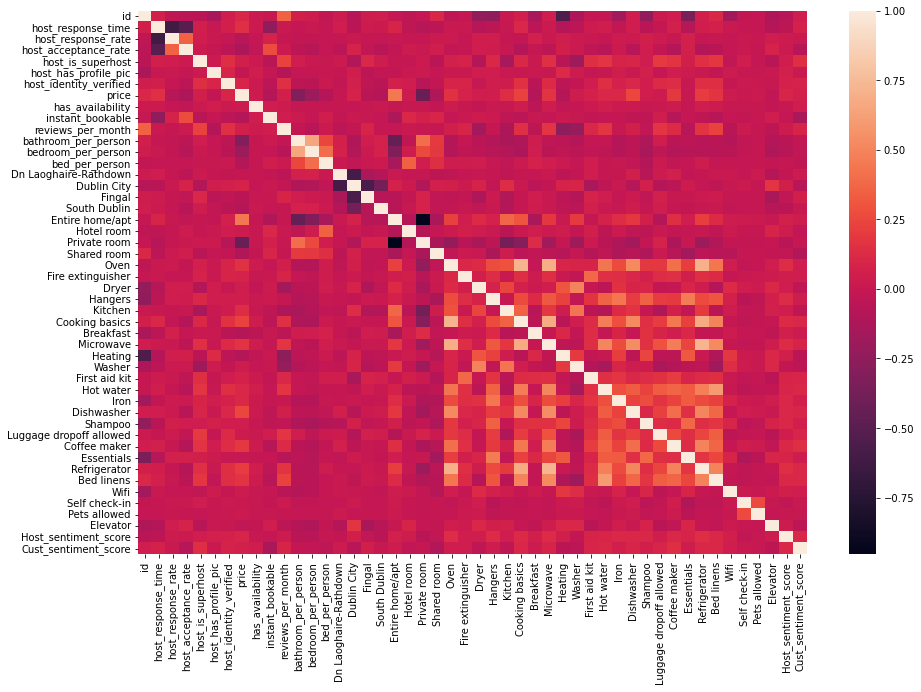

In [21]:
# Correlation analysis
corr = listings_merge.corr()


plt.figure(figsize=(15, 10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

# Modeling

In [22]:
# Split train set and test set

X = listings_merge.drop(columns=['id']).drop(columns=targets)
y = listings_merge[targets]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [23]:
# Min Max Scaling
scaler = MinMaxScaler()
X_train.loc[:,['price', 'reviews_per_month', 'bathroom_per_person', 'bedroom_per_person', 'bed_per_person']] = scaler.fit_transform(X_train.loc[:,['price', 'reviews_per_month', 'bathroom_per_person', 'bedroom_per_person', 'bed_per_person']])
X_test.loc[:,['price', 'reviews_per_month', 'bathroom_per_person', 'bedroom_per_person', 'bed_per_person']] = scaler.transform(X_test.loc[:,['price', 'reviews_per_month', 'bathroom_per_person', 'bedroom_per_person', 'bed_per_person']])

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4967, 47)
(4967, 7)
(1242, 47)
(1242, 7)


Model chosen in this project:

Baseline: Dummy Classifier

Model 1: SVM

Model 2: Random Forest

# Baseline model

In [25]:
# Model
model_dc = DummyClassifier(strategy="most_frequent")
model_lr_init = LogisticRegression()
model_rf_init = RandomForestClassifier()

In [26]:
for target in targets:
  print(target,': ')
  result = dc_result('DC',model_dc,X_train,y_train[target],X_test,y_test[target])
  print(result)

rating_bin : 
  Model dataset  Accuracy  Precision  Recall  F1 score
0    DC   train  0.322730   0.064546     0.2  0.097595
1    DC    test  0.345411   0.069082     0.2  0.102693
accuracy_bin : 
  Model dataset  Accuracy  Precision  Recall  F1 score
0    DC   train  0.324945   0.064989     0.2  0.098101
1    DC    test  0.350242   0.070048     0.2  0.103757
cleanliness_bin : 
  Model dataset  Accuracy  Precision  Recall  F1 score
0    DC   train  0.319710   0.063942     0.2  0.096903
1    DC    test  0.341385   0.068277     0.2  0.101801
checkin_bin : 
  Model dataset  Accuracy  Precision  Recall  F1 score
0    DC   train  0.476545   0.119136    0.25  0.161372
1    DC    test  0.500000   0.125000    0.25  0.166667
communication_bin : 
  Model dataset  Accuracy  Precision  Recall  F1 score
0    DC   train  0.487014   0.121754    0.25  0.163756
1    DC    test  0.519324   0.129831    0.25  0.170906
location_bin : 
  Model dataset  Accuracy  Precision  Recall  F1 score
0    DC   train  0.

# Grid search cross-validation

In [ ]:
param_grid_lr = {'C':[0.001, 0.01, 0.1, 1, 10], 'max_iter':[1000], 'solver':['saga']}
param_grid_rf = {'n_estimators':range(1,101,10), 'max_depth':range(5,20,1)}

# Logistic regression

In [28]:
# Choose best parameter for LR
plr = []

for i in range(7):
  target = targets[i]

  print(target,': ')
  bestp = choose_param(model_lr_init, X_train, y_train[target], param_grid_lr)
  print(bestp)
  plr.append(bestp)

rating_bin : 
{'C': 10, 'max_iter': 1000, 'solver': 'saga'}
accuracy_bin : 
{'C': 10, 'max_iter': 1000, 'solver': 'saga'}
cleanliness_bin : 
{'C': 10, 'max_iter': 1000, 'solver': 'saga'}
checkin_bin : 
{'C': 10, 'max_iter': 1000, 'solver': 'saga'}
communication_bin : 
{'C': 10, 'max_iter': 1000, 'solver': 'saga'}
location_bin : 
{'C': 10, 'max_iter': 1000, 'solver': 'saga'}
value_bin : 
{'C': 10, 'max_iter': 1000, 'solver': 'saga'}


In [29]:
plr

[{'C': 10, 'max_iter': 1000, 'solver': 'saga'},
 {'C': 10, 'max_iter': 1000, 'solver': 'saga'},
 {'C': 10, 'max_iter': 1000, 'solver': 'saga'},
 {'C': 10, 'max_iter': 1000, 'solver': 'saga'},
 {'C': 10, 'max_iter': 1000, 'solver': 'saga'},
 {'C': 10, 'max_iter': 1000, 'solver': 'saga'},
 {'C': 10, 'max_iter': 1000, 'solver': 'saga'}]

In [32]:
# Logistic Regression
result1 = []

for i in range(7):
  param = plr[i]
  target = targets[i]
  model = LogisticRegression(**param)

  print(target,': ')
  result = eva_result('LR',model,X_train,y_train[target],X_test,y_test[target])
  result1.append(result)
  print(result)

rating_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    LR   train  0.445742   0.436750  0.389047  0.384895  0.745051
1    LR    test  0.450886   0.436777  0.394686  0.393793  0.739172
accuracy_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    LR   train  0.448560   0.429741  0.389936  0.387750  0.745939
1    LR    test  0.452496   0.406042  0.377891  0.372993  0.733697
cleanliness_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    LR   train  0.409503   0.391785  0.353662  0.353370  0.712967
1    LR    test  0.389694   0.354350  0.321511  0.320913  0.691795
checkin_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    LR   train  0.530501   0.477992  0.376258  0.378721  0.725041
1    LR    test  0.529791   0.438030  0.360279  0.364070  0.717915
communication_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    LR   train  0.530300   0.458445  0.3664

# Random forest

In [33]:
# Choose best parameter for RF
prf = []

for i in range(7):
  target = targets[i]

  print(target,': ')
  bestp = choose_param(model_rf_init, X_train, y_train[target], param_grid_rf)
  prf.append(bestp)
  print(bestp)

rating_bin : 
{'max_depth': 17, 'n_estimators': 96}
accuracy_bin : 
{'max_depth': 14, 'n_estimators': 86}
cleanliness_bin : 
{'max_depth': 13, 'n_estimators': 86}
checkin_bin : 
{'max_depth': 16, 'n_estimators': 71}
communication_bin : 
{'max_depth': 18, 'n_estimators': 86}
location_bin : 
{'max_depth': 13, 'n_estimators': 86}
value_bin : 
{'max_depth': 11, 'n_estimators': 96}


In [34]:
prf

[{'max_depth': 17, 'n_estimators': 96},
 {'max_depth': 14, 'n_estimators': 86},
 {'max_depth': 13, 'n_estimators': 86},
 {'max_depth': 16, 'n_estimators': 71},
 {'max_depth': 18, 'n_estimators': 86},
 {'max_depth': 13, 'n_estimators': 86},
 {'max_depth': 11, 'n_estimators': 96}]

In [ ]:
# Random Forest
result2 = []

for i in range(7):
  param = prf[i]
  target = targets[i]
  model = RandomForestClassifier(**param)

  print(target,': ')
  result = eva_result('RF',model,X_train,y_train[target],X_test,y_test[target])
  result2.append(result)
  print(result)

rating_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    RF   train  0.994967   0.995562  0.994233  0.994889  0.999848
1    RF    test  0.482287   0.450370  0.427359  0.426967  0.790316
accuracy_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    RF   train  0.775720   0.812336  0.745476  0.765298  0.961808
1    RF    test  0.532206   0.488802  0.466664  0.461217  0.793389
cleanliness_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    RF   train  0.998993   0.998818  0.999259  0.999038  0.999950
1    RF    test  0.443639   0.409589  0.381639  0.384693  0.740142
checkin_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    RF   train  0.997181   0.998530  0.995920  0.997214  0.999979
1    RF    test  0.580515   0.518597  0.428835  0.446333  0.785728
communication_bin : 
  Model dataset  Accuracy  Precision    Recall  F1 score   ROC_AUC
0    RF   train  0.985907   0.992155  0.9796

# Feature importance

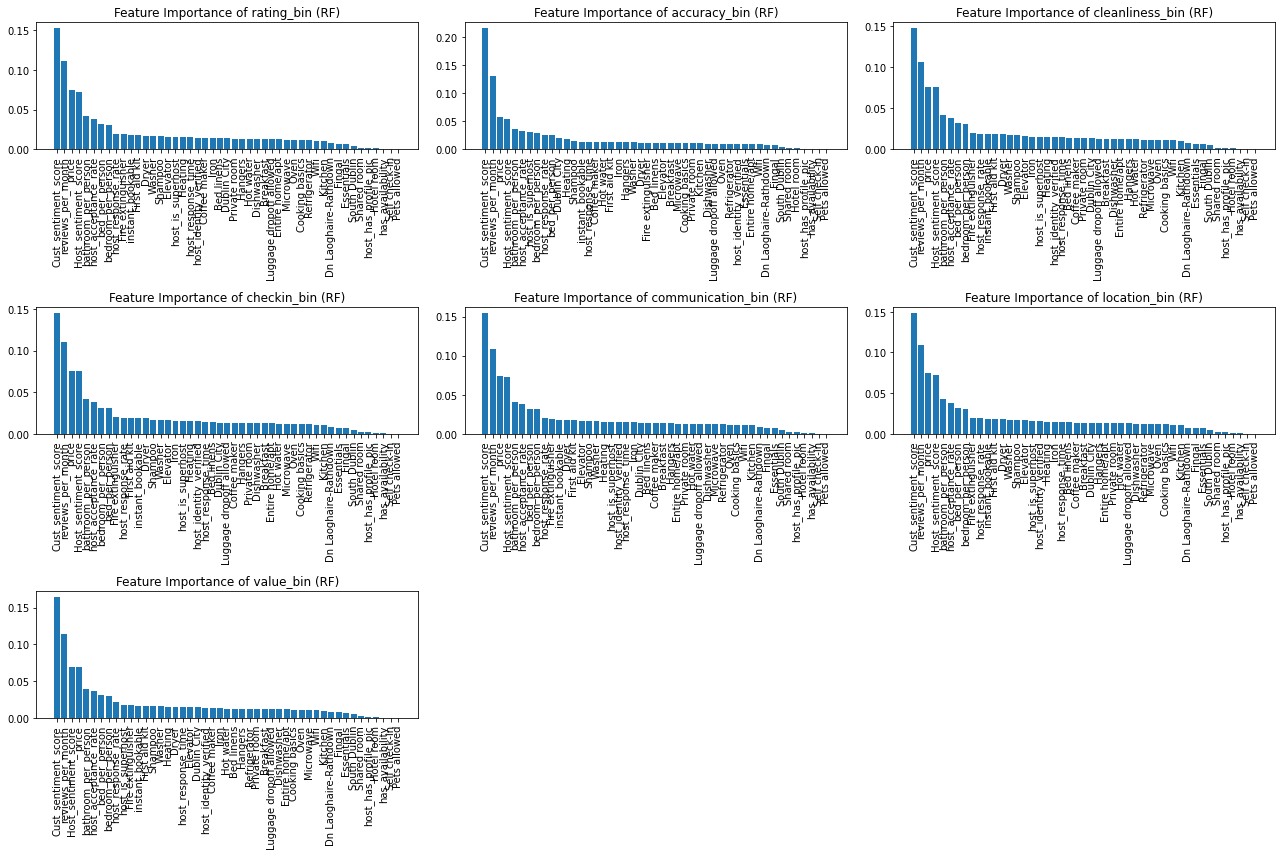

In [ ]:

fig = plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=1, wspace=1)

for i in range(7):
  param = prf[i]
  target = targets[i]
  model = RandomForestClassifier(**param)
  model.fit(X_train, y_train)
  importances = model.feature_importances_
  sort = np.argsort(importances)[::-1]
  plt.subplot(3, 3, i+1)
  plt.title(f"Feature Importance of {target} (RF)")
  plt.bar(range(X_train.shape[1]), importances[sort], align='center')
  plt.xticks(range(X_train.shape[1]), X_train.columns[sort], rotation=90)
  plt.tight_layout()

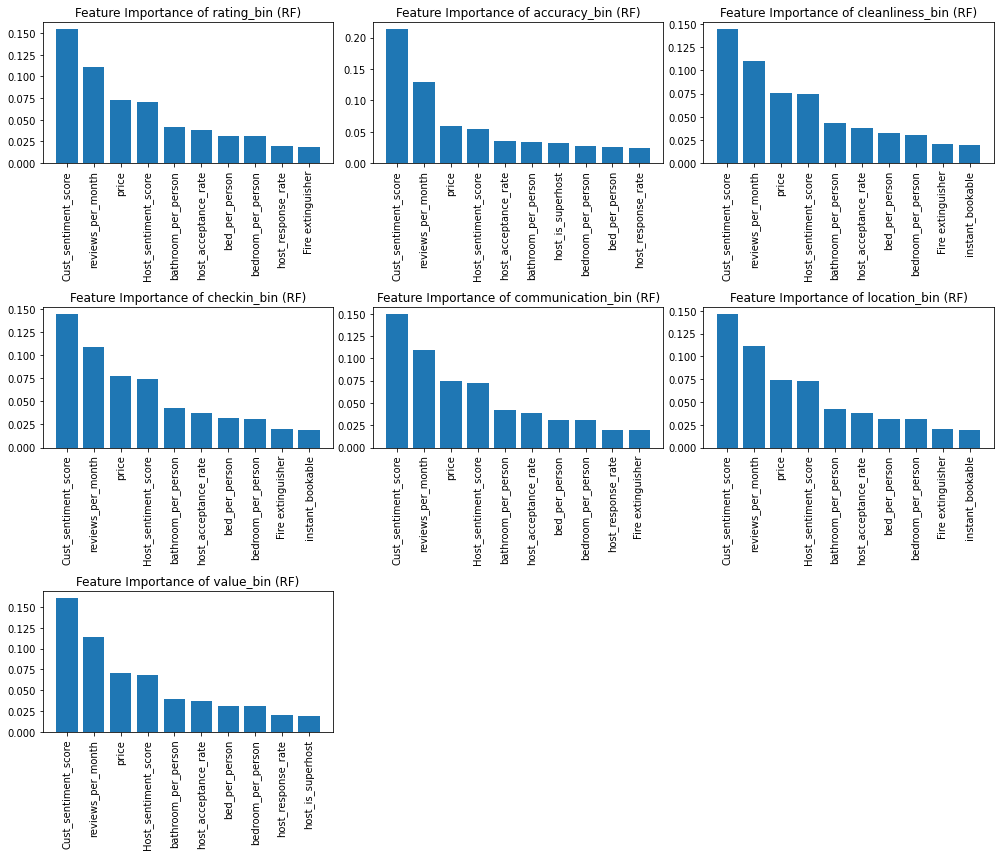

In [ ]:

fig = plt.figure(figsize=(14,12))
plt.subplots_adjust(hspace=1, wspace=1)

for i in range(7):
  param = prf[i]
  target = targets[i]
  model = RandomForestClassifier(**param)
  model.fit(X_train, y_train)
  importances = model.feature_importances_
  sort = np.argsort(importances)[::-1]
  imp = importances[sort]
  xcol = X_train.columns[sort]

  plt.subplot(3, 3, i+1)
  plt.title(f"Feature Importance of {target} (RF)")
  plt.bar(range(10), imp[:10], align='center')
  plt.xticks(range(10), xcol[:10], rotation=90)
  plt.tight_layout()